# Credit Card Fraud Detection Project
* Dataset : https://www.kaggle.com/mlg-ulb/creditcardfraud

* The Aim of the project is to create a model to predict if a credit card transaction is fradulent or not. The dataset contains transaction data over 2 days with target variable as 'Class' where '1' represents fraudulent transaction and '0' represents otherwise.

* Please note that there are many possible ways the model metrics can be improved. Due to computational contraint, I have limited grid search parameters.

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #set style as seaborn
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans,MiniBatchKMeans

In [2]:
df_orig=pd.read_csv('creditcard.csv')

## Exploratory Data Analysis

## About the Dataset:
* There is 31 columns and around 284k rows.
* There are no null values in the dataset.
* The Columns V1-V28 represent columns anonymized with PCA
* Most of the columns don't have normal distribution

In [3]:
print('Shape : {}'.format(df_orig.shape))
print('Columns : {}'.format(df_orig.columns))

Shape : (284807, 31)
Columns : Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

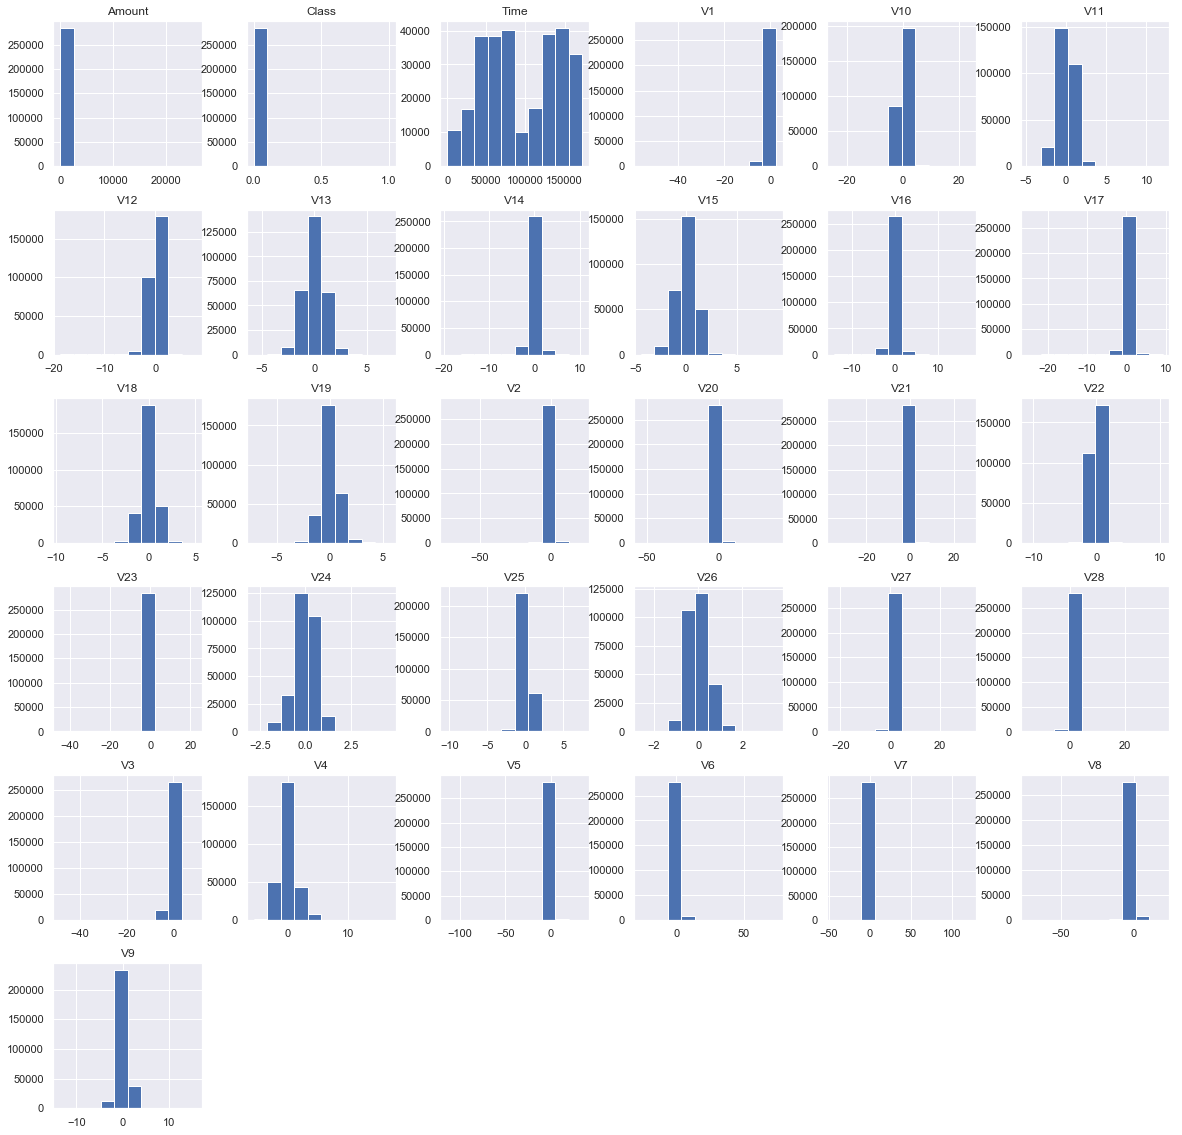

In [161]:
df_orig.hist(figsize=(20,20))
plt.show()

## Count Plot
* From the below countplot we could see the dependent variable 'Class' is **heavily imbalanced**

0    284315
1       492
Name: Class, dtype: int64


Text(0.5,1,'Class imbalance')

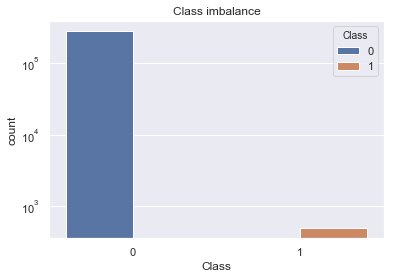

In [5]:
print(df_orig.Class.value_counts())
sns.countplot(x='Class',hue='Class',data=df_orig)
plt.yscale('log')
plt.xlabel('Class')
plt.ylabel('count')
plt.title('Class imbalance')

## Correlation Matrix HeatMap
* From the below heatmap, we could see V3, V12, V14, V17 have high negative correlation with Class variable

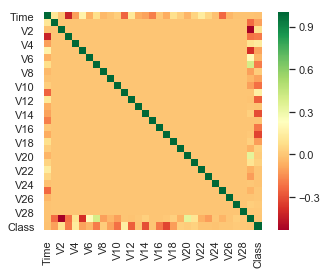

In [163]:
sns.heatmap(df_orig.corr(),square=True,cmap='RdYlGn')
plt.show()

## Train Test Split
* Due to computational contraint we will be working on 10% of the dataset

In [7]:
#df=df_orig.sample(frac=.1,random_state=0)
#df=df_orig

X=df_orig.iloc[:,:-1];y=df_orig.iloc[:,-1]
Xtr,Xte,ytr,yte=train_test_split(X,y,random_state=0, test_size=.1, shuffle=True ,stratify=y)
print(Xtr.shape,Xte.shape,ytr.shape,yte.shape)

(256326, 30) (28481, 30) (256326,) (28481,)


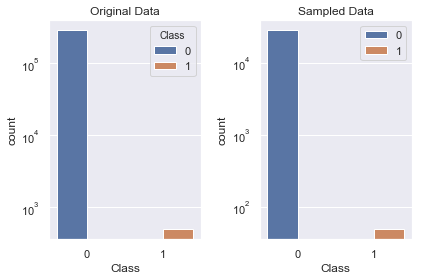

Original Dataset Class count: [284315    492]
Sample Dataset Class count: [28432    49]


In [10]:
plt.subplot(1,2,1)
sns.countplot(x='Class',hue='Class',data=df_orig)
plt.yscale('log')
plt.xlabel('Class')
plt.ylabel('count')
plt.title('Original Data')
plt.subplot(1,2,2)
#sns.countplot(x='Class',hue='Class',data=df)
sns.countplot(x=yte.values,hue=yte.values,data=yte)
plt.yscale('log')
plt.xlabel('Class')
plt.ylabel('count')
plt.title('Sampled Data')
plt.tight_layout() #To improve spacing between subplots
plt.show()

print('Original Dataset Class count: {}'.format(df_orig.Class.value_counts().values))
print('Sample Dataset Class count: {}'.format(np.bincount(yte)))

In [12]:
#df_down=df_orig[ind]
X=Xte;y=yte
X_train,Xtest,ytrain,ytest=train_test_split(X,y,random_state=0, test_size=.3, shuffle=True ,stratify=y)
print(X_train.shape,Xtest.shape,ytrain.shape,ytest.shape)

(19936, 30) (8545, 30) (19936,) (8545,)


## Scaling
* Since the input data has non-normal distribution, we use **Standard Scaler**
* We use **MinMaxScaler** to make the algorithms weigh each input columns without bias due to high variance

In [14]:
ss_scaler = StandardScaler()
Xtrain=pd.DataFrame(ss_scaler.fit_transform(X_train))
Xtest=ss_scaler.transform(Xtest)

mm_scaler = MinMaxScaler()
Xtrain=pd.DataFrame(mm_scaler.fit_transform(Xtrain))
Xtest=mm_scaler.transform(Xtest)
Xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,...,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000,19936.000000
mean,0.550336,0.937322,0.819658,0.855154,0.294559,0.519546,0.495802,0.408865,0.808214,0.494097,...,0.581505,0.472643,0.596548,0.489454,0.413385,0.434995,0.321526,0.559528,0.268712,0.011611
std,0.274565,0.049784,0.028607,0.054273,0.085100,0.022424,0.032806,0.022667,0.023045,0.068526,...,0.019413,0.017196,0.050538,0.015520,0.088896,0.039498,0.092690,0.025638,0.011220,0.031059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.314073,0.914103,0.809277,0.822376,0.243219,0.507886,0.476939,0.398312,0.804285,0.454325,...,0.576111,0.467217,0.558824,0.485370,0.361168,0.411182,0.258776,0.555164,0.267080,0.000782
50%,0.492977,0.937932,0.820961,0.861645,0.292905,0.518606,0.489122,0.409616,0.808803,0.490937,...,0.579975,0.471847,0.597099,0.489078,0.419562,0.436284,0.310613,0.559701,0.269156,0.002871
75%,0.805741,0.970846,0.833652,0.892446,0.338330,0.529668,0.505887,0.419719,0.814766,0.531186,...,0.584896,0.476991,0.633100,0.492947,0.478234,0.461373,0.367023,0.565490,0.271343,0.010221
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## SMOTE
* We have a heavily imbalanced dataset as seen in the countplots and we need to address the same.
* In **Random Under Sampling** removing huge data will lead to loss of potentially useful data.
* In **Random Over Sampling** making copies of few datapoints the model may tend to overfit.
* We use **SMOTE** to synthetically oversample minority class and avoiding the above stated disadvantages.

In [15]:
smot = SMOTE(kind='borderline2')
X_smote,y_smote=smot.fit_sample(Xtrain,ytrain)

print(np.bincount(y_smote), np.bincount(ytrain))

[19902 19901] [19902    34]


### TSNE plot to visualize effect of SMOTE

* TSNE is a Dimentionality reduction technique which can be used to plot 2D graphs with data from higher dimensions

In [16]:
#DIMENSION REDUCTION USING TSNE

model=TSNE(learning_rate=200)
features=model.fit_transform(Xtrain.values)
print(type(features),features.shape)
xs_before = features[:,0]
ys_before = features[:,1]
print('Number of X and Y points BEFORE SMOTE : ',str(xs_before.shape[0]),' , ',str(ys_before.shape[0]))

model=TSNE(learning_rate=200)
features=model.fit_transform(X_smote)
#print(type(features),features.shape)
xs_after = features[:,0]
ys_after = features[:,1]
print('\nNumber of X and Y points AFTER SMOTE : ',str(xs_after.shape[0]),' , ',str(ys_after.shape[0]))


<class 'numpy.ndarray'> (19936, 2)
Number of X and Y points BEFORE SMOTE :  19936  ,  19936

Number of X and Y points AFTER SMOTE :  39803  ,  39803


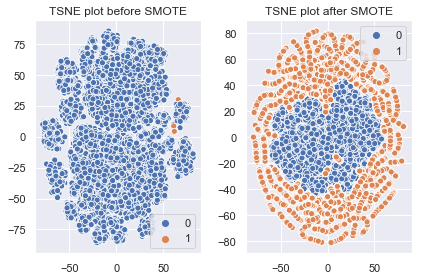

In [17]:
#PLOT 
plt.subplot(1,2,1)
sns.scatterplot(x=xs_before,y=ys_before,hue=ytrain.values)
plt.title('TSNE plot before SMOTE')

plt.subplot(1,2,2)
sns.scatterplot(x=xs_after,y=ys_after,hue=y_smote)
plt.title('TSNE plot after SMOTE')
plt.tight_layout() #To improve spacing between subplots
plt.show()

## SUPERVISED LEARNING

### GridSearch and Metrics
* We use GridSearchCV to traverse between different hyperparameter combinations to get the best score.
* Since this is a classification problem, we use metrics such as Area Under Receiver Operating Curve, Classification report to provide Recall and Precision values.

### Logistic Regression
* To start with, we use the most common binary classifier the Logistic Regression

In [19]:
grid = {'penalty' : ['l1','l2'], 'C' : [0.1, 1, 10]}
lr=LogisticRegression(random_state=0)
lr_grid = GridSearchCV(estimator=lr, param_grid=grid, cv=5, scoring='recall', n_jobs=-1)
lr_grid.fit(X_smote,y_smote)
lr_best_params=lr_grid.best_params_

C:\Users\mahee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
print(lr_best_params)
lr_best=LogisticRegression(random_state=0,penalty=lr_best_params['penalty'],C=lr_best_params['C'])
lr_best.fit(X_smote,y_smote) #fit
y_pred=lr_best.predict(Xtest) #predit
probs=lr_best.predict_proba(Xtest) #predict probability
print('\n ROC AUC SCORE: \n',roc_auc_score(ytest,probs[:,1]))
print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred))

{'C': 10, 'penalty': 'l1'}


C:\Users\mahee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 ROC AUC SCORE: 
 0.8977178585384916

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.57      0.87      0.68        15

   micro avg       1.00      1.00      1.00      8545
   macro avg       0.78      0.93      0.84      8545
weighted avg       1.00      1.00      1.00      8545


 CONFUSION MATRIX: 
 [[8520   10]
 [   2   13]]


### Random Forest Classifier

In [21]:
#GRID SEARCH
grid = {'n_estimators': [100,200], 'max_features': ['auto', 'log2'],
              'max_depth': [1,5,10], 'criterion': ['gini', 'entropy']}
#grid={'n_estimators': [10,20]}

rf=RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5, scoring='recall', n_jobs=-1)
rf_grid.fit(X_smote,y_smote)
rf_best_params=rf_grid.best_params_

In [22]:
print(rf_best_params)
rf_best=RandomForestClassifier(random_state=0,n_estimators=rf_best_params['n_estimators'],max_depth=rf_best_params['max_depth'],
                               max_features=rf_best_params['max_features'],criterion=rf_best_params['criterion'])
rf_best.fit(X_smote,y_smote) #fit
y_pred=rf_best.predict(Xtest) #predit
probs=rf_best.predict_proba(Xtest) #predict probability
print('\n ROC AUC SCORE: \n',roc_auc_score(ytest,probs[:,1]))
print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred))

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}

 ROC AUC SCORE: 
 0.9263618601016023

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       1.00      0.73      0.85        15

   micro avg       1.00      1.00      1.00      8545
   macro avg       1.00      0.87      0.92      8545
weighted avg       1.00      1.00      1.00      8545


 CONFUSION MATRIX: 
 [[8530    0]
 [   4   11]]


### KNN Classifier

In [23]:
grid = {'n_neighbors': [5,10,15]}
knn=KNeighborsClassifier()
knn_grid=GridSearchCV(estimator=knn, param_grid=grid, cv=5, scoring='recall', n_jobs=-1)
knn_grid.fit(X_smote,y_smote)
knn_best_params=knn_grid.best_params_

In [24]:
print(knn_best_params)
knn_best=KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'])
knn_best.fit(X_smote,y_smote) #fit
y_pred=knn_best.predict(Xtest) #predit
probs=knn_best.predict_proba(Xtest) #predict probability
print('\n ROC AUC SCORE: \n',roc_auc_score(ytest,probs[:,1]))
print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred))

{'n_neighbors': 10}

 ROC AUC SCORE: 
 0.9329855412270419

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.62      0.87      0.72        15

   micro avg       1.00      1.00      1.00      8545
   macro avg       0.81      0.93      0.86      8545
weighted avg       1.00      1.00      1.00      8545


 CONFUSION MATRIX: 
 [[8522    8]
 [   2   13]]


## Voting Classifier
* We use hard and soft voting classifiers to get the most out of the best parameters for each algorithm obtained through Grid Search

#### SOFT VOTING

In [25]:
sv = VotingClassifier(estimators=[('rf', rf_best), ('lr', lr_best), ('knn', knn_best)], voting='soft')
sv.fit(X_smote,y_smote) #fit
y_pred = sv.predict(Xtest) #predict
probs=sv.predict_proba(Xtest) #predict probability
print('\n ROC AUC SCORE: \n',roc_auc_score(ytest,probs[:,1]))
print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred))

C:\Users\mahee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 ROC AUC SCORE: 
 0.895052754982415

 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.87      0.87      0.87        15

   micro avg       1.00      1.00      1.00      8545
   macro avg       0.93      0.93      0.93      8545
weighted avg       1.00      1.00      1.00      8545


 CONFUSION MATRIX: 
 [[8528    2]
 [   2   13]]


#### HARD VOTING

In [26]:
hv = VotingClassifier(estimators=[('rf', rf_best), ('lr', lr_best), ('knn', knn_best)], voting='hard')
hv.fit(X_smote,y_smote) #fit
y_pred = hv.predict(Xtest) #predict

print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred))

C:\Users\mahee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8530
           1       0.87      0.87      0.87        15

   micro avg       1.00      1.00      1.00      8545
   macro avg       0.93      0.93      0.93      8545
weighted avg       1.00      1.00      1.00      8545


 CONFUSION MATRIX: 
 [[8528    2]
 [   2   13]]


## UNSUPERVISED LEARNING
* In real world scenario, we usually deal with unlabelled dataset and our aim is to distinguish between normal data from abnormal data
* We use **KMeans clustering** technique and find the optimal number of clusters. we separate those data points which we consider as outliers and label them as abnormal / fraudulent.

[3413.242817069468, 2145.4541152846723, 2018.355485931026, 1932.803991207759, 1861.8758039008878, 1800.748122966299, 1753.3324768684163, 1712.8824388380337, 1671.5196249505393]


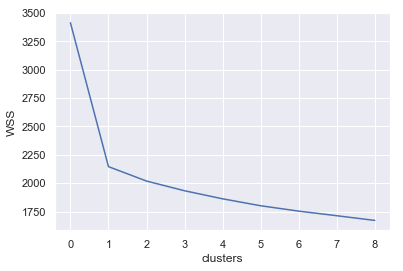

In [61]:
for k in range (1,10):
    km=[KMeans(n_clusters=k,random_state=0) for k in range(1,10)]
wss=[km[i].fit(Xtrain).inertia_ for i in range(len(km))]
print(wss)
plt.plot(range(len(km)),wss)
plt.xlabel('clusters')
plt.ylabel('WSS')
plt.show()

### Mini Batch KMeans
* When dealing with huge datasets we use MiniBatchKmeans which clusters using repeated subset of the datapoints.

[3413.820505760992, 2149.1429222577444, 2027.5561886424787, 1961.364264978812, 1905.955984379297, 1826.8439898834577, 1805.656839323169, 1795.5272567883121, 1803.49707856241]


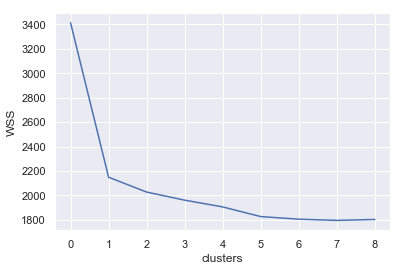

In [62]:
for k in range (1,10):
    mbkm=[MiniBatchKMeans(n_clusters=k,random_state=0) for k in range(1,10)]
wss=[mbkm[i].fit(Xtrain).inertia_ for i in range(len(mbkm))]
print(wss)
plt.plot(range(len(mbkm)),wss)
plt.xlabel('clusters')
plt.ylabel('WSS')
plt.show()

In [82]:
kmeans=KMeans(n_clusters=1,random_state=0)
kmeans.fit(Xtrain)
X_test_clusters = kmeans.predict(Xtest)
X_test_clusters_centers = kmeans.cluster_centers_

dista = [np.linalg.norm(x-y) for x, y in zip(Xtest, X_test_clusters_centers[X_test_clusters])]

#Finding outliers on clusters to label them as fraud
km_y_pred = np.array(dista)
km_y_pred[dista >= np.percentile(dista, 96.3)] = 1
km_y_pred[dista < np.percentile(dista, 96.3)] = 0

confusion_matrix(ytest,km_y_pred)

print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,km_y_pred))
print('\n CONFUSION MATRIX: \n',confusion_matrix(ytest,km_y_pred))



 CLASSIFICATION REPORT: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      8530
           1       0.04      0.87      0.08        15

   micro avg       0.96      0.96      0.96      8545
   macro avg       0.52      0.92      0.53      8545
weighted avg       1.00      0.96      0.98      8545


 CONFUSION MATRIX: 
 [[8226  304]
 [   2   13]]


# Conclusion
* To decide on the best models, we need to look up on various metrics of a model.
    * In Credit Card Fraud Detection, misclassification of Fraudulent cases as non-fraudulent leads to huge cost to business.
    * A best model has least False Negatives and most True Positives.
    * **Recall** provides the required score. More the Recall, better the model for this case.

###  Best Models
* **Supervised Learning**: KNN Classifier does a good job with **recall of .87** and **roc_auc_score of 0.9329**
* **Unsupervised Learning**: With KMeans Clustering technique and labeling outliers above 96.3 percentile of distance from cetroid, we could get a **recall of .93**

###  Additional Points
* With more computational power we can process complete dataset and get better results
* We can also adjust the threshold probability of binary classifiers to adapt with business needs. (i.e to trade off between False Positives and Fall Negatives). Please find the code below

In [185]:
#TO MANIPULATE THRESHOLD VALUE AS PER BUSINESS NEEDS

'''pone=.001
pzero=.96
out=np.zeros(len(probs[:,0]))
out[(probs[:,1] >=pone)]=1
out=out.astype(int)

print(np.bincount(y_pred))
print('CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred),'\n\n')

print(np.bincount(out))
print('CONFUSION MATRIX: \n',confusion_matrix(ytest,out))
print('\n CLASSIFICATION REPORT: \n',classification_report(ytest,out))'''

"pone=.001\npzero=.96\nout=np.zeros(len(probs[:,0]))\nout[(probs[:,1] >=pone)]=1\nout=out.astype(int)\n\nprint(np.bincount(y_pred))\nprint('CONFUSION MATRIX: \n',confusion_matrix(ytest,y_pred),'\n\n')\n\nprint(np.bincount(out))\nprint('CONFUSION MATRIX: \n',confusion_matrix(ytest,out))\nprint('\n CLASSIFICATION REPORT: \n',classification_report(ytest,out))"